1. Missing Values: Identify and handle missing values, especially in key columns like reviews_per_month (which might be legitimately null or 0 if number_of_reviews is 0) and last_review.
Han, J., Pei, J. and Tong, H. (2022, Chapter 3: Data Preprocessing) provide comprehensive techniques for handling missing data.


1.1 Load Data

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("..\\data\\AB_NYC_2019.csv")
print("Dataset loaded. Shape:", df.shape)
df.head()

Dataset loaded. Shape: (48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


1.2 Overall Missing Value Summary

In [2]:
print("--- Overall Missing Value Counts ---")
missing_values_summary = df.isnull().sum()
print(missing_values_summary[missing_values_summary > 0])

--- Overall Missing Value Counts ---
name                    16
host_name               21
last_review          10052
reviews_per_month    10052
dtype: int64


1.3 Analyze Missing reviews_per_month

In [3]:
print("--- Analyzing Missing 'reviews_per_month' ---")
if 'reviews_per_month' in df.columns and 'number_of_reviews' in df.columns:
    total_nan_rpm = df['reviews_per_month'].isnull().sum()
    print(f"Total NaN values in 'reviews_per_month': {total_nan_rpm}")

    listings_with_zero_reviews = df[df['number_of_reviews'] == 0]
    print(f"Number of listings with 0 reviews: {len(listings_with_zero_reviews)}")

    nan_rpm_when_zero_reviews = 0
    if not listings_with_zero_reviews.empty:
        nan_rpm_when_zero_reviews = listings_with_zero_reviews['reviews_per_month'].isnull().sum()
    print(f"NaN in 'reviews_per_month' when 'number_of_reviews' is 0: {nan_rpm_when_zero_reviews}")

    if total_nan_rpm > 0 and total_nan_rpm == nan_rpm_when_zero_reviews and len(listings_with_zero_reviews) == total_nan_rpm:
        print("\nObservation: All NaN values in 'reviews_per_month' occur where 'number_of_reviews' is 0.")
        print("Interpretation: This is expected. If there are no reviews, 'reviews_per_month' cannot be calculated and is thus NaN.")
        print("Proposed Strategy for next step: Impute these NaNs with 0.")
    else:
        nan_rpm_with_reviews = df[(df['reviews_per_month'].isnull()) & (df['number_of_reviews'] > 0)]
        count_nan_rpm_with_reviews = len(nan_rpm_with_reviews)
        print(f"\nNumber of listings with 'reviews_per_month' = NaN BUT 'number_of_reviews' > 0: {count_nan_rpm_with_reviews}")
        if count_nan_rpm_with_reviews > 0:
            print("Observation: There are unexpected NaNs in 'reviews_per_month' for listings that DO have reviews. These need further investigation or a specific imputation strategy for them.")
        elif total_nan_rpm > 0 :
             print("\nObservation: 'reviews_per_month' has NaN values. The primary cause appears to be listings with 0 reviews.")
             print("Proposed Strategy for next step: For NaNs corresponding to 0 reviews, impute with 0. Investigate any other NaNs if present.")
        elif total_nan_rpm == 0:
            print("\nNo NaN values found in 'reviews_per_month'.")
        else:
            print("\nMixed observations about NaNs in 'reviews_per_month'. Review distribution carefully.")
else:
    print("Error: 'reviews_per_month' or 'number_of_reviews' column not found in DataFrame.")

--- Analyzing Missing 'reviews_per_month' ---
Total NaN values in 'reviews_per_month': 10052
Number of listings with 0 reviews: 10052
NaN in 'reviews_per_month' when 'number_of_reviews' is 0: 10052

Observation: All NaN values in 'reviews_per_month' occur where 'number_of_reviews' is 0.
Interpretation: This is expected. If there are no reviews, 'reviews_per_month' cannot be calculated and is thus NaN.
Proposed Strategy for next step: Impute these NaNs with 0.


1.4 Analyze Missing last_review

In [4]:
print("\n--- Analyzing Missing 'last_review' ---")
if 'last_review' in df.columns and 'number_of_reviews' in df.columns:
    total_nan_last_review = df['last_review'].isnull().sum()
    print(f"Total NaN values in 'last_review': {total_nan_last_review}")

    # Assuming 'listings_with_zero_reviews' is still relevant from the previous cell's scope
    # or re-calculate if running cells out of strict order:
    # listings_with_zero_reviews = df[df['number_of_reviews'] == 0]
    # print(f"Number of listings with 0 reviews: {len(listings_with_zero_reviews)}")


    nan_last_review_when_zero_reviews = 0
    # Re-filter to ensure 'listings_with_zero_reviews' is defined in this cell's scope if run independently
    listings_with_zero_reviews_for_last_review_check = df[df['number_of_reviews'] == 0]
    if not listings_with_zero_reviews_for_last_review_check.empty:
        nan_last_review_when_zero_reviews = listings_with_zero_reviews_for_last_review_check['last_review'].isnull().sum()
    print(f"NaN in 'last_review' when 'number_of_reviews' is 0: {nan_last_review_when_zero_reviews}")

    if total_nan_last_review > 0 and total_nan_last_review == nan_last_review_when_zero_reviews and len(listings_with_zero_reviews_for_last_review_check) == total_nan_last_review:
        print("\nObservation: All NaN values in 'last_review' occur where 'number_of_reviews' is 0.")
        print("Interpretation: This is expected. If there are no reviews, there is no 'last_review' date.")
        print("Proposed Strategy: These NaNs are informative. No direct imputation of the date is usually needed for these expected NaNs. If creating a 'days_since_last_review' feature, these would become NaN or a special large value.")
    else:
        nan_last_review_with_reviews = df[(df['last_review'].isnull()) & (df['number_of_reviews'] > 0)]
        count_nan_last_review_with_reviews = len(nan_last_review_with_reviews)
        print(f"\nNumber of listings with 'last_review' = NaN BUT 'number_of_reviews' > 0: {count_nan_last_review_with_reviews}")
        if count_nan_last_review_with_reviews > 0:
            print("Observation: There are unexpected NaNs in 'last_review' for listings that DO have reviews. These require investigation.")
        elif total_nan_last_review > 0:
            print("\nObservation: 'last_review' has NaN values. The primary cause appears to be listings with 0 reviews.")
        elif total_nan_last_review == 0:
            print("\nNo NaN values found in 'last_review'.")
        else:
            print("\nMixed observations about NaNs in 'last_review'. Review distribution carefully.")
else:
    print("Error: 'last_review' or 'number_of_reviews' column not found in DataFrame.")


--- Analyzing Missing 'last_review' ---
Total NaN values in 'last_review': 10052
NaN in 'last_review' when 'number_of_reviews' is 0: 10052

Observation: All NaN values in 'last_review' occur where 'number_of_reviews' is 0.
Interpretation: This is expected. If there are no reviews, there is no 'last_review' date.
Proposed Strategy: These NaNs are informative. No direct imputation of the date is usually needed for these expected NaNs. If creating a 'days_since_last_review' feature, these would become NaN or a special large value.


1.5 Analyze Other Minor Missing Values (name, host_name)

In [5]:
print("\n--- Analyzing Other Minor Missing Values ('name', 'host_name') ---")
minor_missing_cols_info = []

if 'name' in df.columns:
    missing_name_count = df['name'].isnull().sum()
    if missing_name_count > 0:
        print(f"Missing values in 'name': {missing_name_count} ({(missing_name_count/len(df)*100):.2f}%)")
        minor_missing_cols_info.append("'name'")
    else:
        print("No missing values in 'name'.")
else:
    print("Column 'name' not found.")

if 'host_name' in df.columns:
    missing_host_name_count = df['host_name'].isnull().sum()
    if missing_host_name_count > 0:
        print(f"Missing values in 'host_name': {missing_host_name_count} ({(missing_host_name_count/len(df)*100):.2f}%)")
        minor_missing_cols_info.append("'host_name'")
    else:
        print("No missing values in 'host_name'.")
else:
    print("Column 'host_name' not found.")

if minor_missing_cols_info:
    print(f"\nObservation: Columns {', '.join(minor_missing_cols_info)} have a very small number of missing values.")
    print("Proposed Strategy for next steps: Impute with a placeholder like 'Unknown' or 'Not Specified'.")


--- Analyzing Other Minor Missing Values ('name', 'host_name') ---
Missing values in 'name': 16 (0.03%)
Missing values in 'host_name': 21 (0.04%)

Observation: Columns 'name', 'host_name' have a very small number of missing values.
Proposed Strategy for next steps: Impute with a placeholder like 'Unknown' or 'Not Specified'.


 1.6 Impute Missing reviews_per_month

In [6]:
print("\n--- Imputing 'reviews_per_month' ---")
if 'reviews_per_month' in df.columns:
    print(f"Missing 'reviews_per_month' before imputation: {df['reviews_per_month'].isnull().sum()}")
    df['reviews_per_month'] = df['reviews_per_month'].fillna(0) # Recommended change
    print(f"Missing 'reviews_per_month' after imputation with 0: {df['reviews_per_month'].isnull().sum()}")
    print("\nSample of 'number_of_reviews' and 'reviews_per_month' after imputation:")
    # Ensure listings_with_zero_reviews is defined or filter again if needed for this check
    listings_with_zero_reviews = df[df['number_of_reviews'] == 0]
    print(listings_with_zero_reviews[['number_of_reviews', 'reviews_per_month']].head())
else:
    print("Error: 'reviews_per_month' column not found for imputation.")


--- Imputing 'reviews_per_month' ---
Missing 'reviews_per_month' before imputation: 10052
Missing 'reviews_per_month' after imputation with 0: 0

Sample of 'number_of_reviews' and 'reviews_per_month' after imputation:
    number_of_reviews  reviews_per_month
2                   0                0.0
19                  0                0.0
26                  0                0.0
36                  0                0.0
38                  0                0.0


1.7 Impute Missing name

In [7]:
print("\n--- Imputing 'name' ---")
if 'name' in df.columns:
    print(f"Missing 'name' before imputation: {df['name'].isnull().sum()}")
    df['name'] = df['name'].fillna('Unknown') # Recommended change
    print(f"Missing 'name' after imputation with 'Unknown': {df['name'].isnull().sum()}")
else:
    print("Error: 'name' column not found for imputation.")


--- Imputing 'name' ---
Missing 'name' before imputation: 16
Missing 'name' after imputation with 'Unknown': 0


1.8 Impute Missing host_name

In [8]:
print("\n--- Imputing 'host_name' ---")
if 'host_name' in df.columns:
    print(f"Missing 'host_name' before imputation: {df['host_name'].isnull().sum()}")
    df['host_name'] = df['host_name'].fillna('Unknown') # Recommended change
    print(f"Missing 'host_name' after imputation with 'Unknown': {df['host_name'].isnull().sum()}")
else:
    print("Error: 'host_name' column not found for imputation.")


--- Imputing 'host_name' ---
Missing 'host_name' before imputation: 21
Missing 'host_name' after imputation with 'Unknown': 0


1.9 Final Check of Missing Values

In [9]:
print("\n--- Final Check of Missing Values After Imputations ---")
if not df.empty:
    final_missing_summary = df.isnull().sum()
    missing_after_imputation = final_missing_summary[final_missing_summary > 0]
    if missing_after_imputation.empty:
        print("No more missing values in 'name', 'host_name', 'reviews_per_month'.")
    else:
        print("Remaining missing values:")
        print(missing_after_imputation)
        if 'last_review' in missing_after_imputation.index:
            print("Note: 'last_review' will still show NaNs if listings had 0 reviews, which is expected and typically not imputed with a date.")
else:
    print("DataFrame 'df' is not loaded. Cannot perform final check.")


--- Final Check of Missing Values After Imputations ---
Remaining missing values:
last_review    10052
dtype: int64
Note: 'last_review' will still show NaNs if listings had 0 reviews, which is expected and typically not imputed with a date.


2. Understanding "Busyness" and Demand Indicators (at neighbourhood and neighbourhood_group levels)

2.1 Setup for Visualizations

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set_palette("viridis")

2.2 Availability Analysis - Overall Distribution of availability_365

--- Availability Analysis: Overall Distribution of availability_365 ---


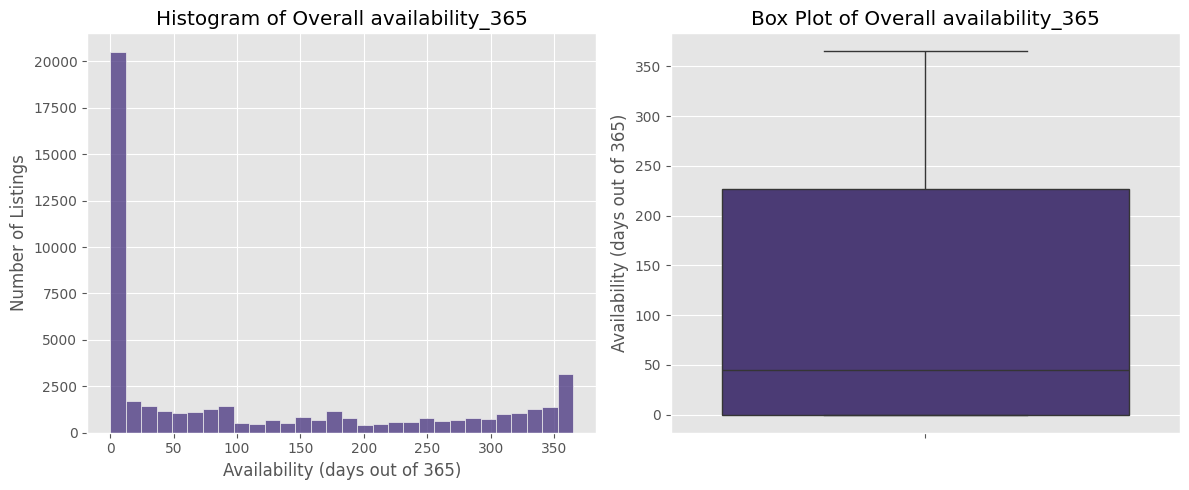


Description of availability_365:
count    48895.000000
mean       112.781327
std        131.622289
min          0.000000
25%          0.000000
50%         45.000000
75%        227.000000
max        365.000000
Name: availability_365, dtype: float64

Number of listings with 0 availability: 17533


In [11]:
print("--- Availability Analysis: Overall Distribution of availability_365 ---")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['availability_365'], bins=30, kde=False)
plt.title('Histogram of Overall availability_365')
plt.xlabel('Availability (days out of 365)')
plt.ylabel('Number of Listings')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['availability_365'])
plt.title('Box Plot of Overall availability_365')
plt.ylabel('Availability (days out of 365)')

plt.tight_layout()
plt.show()

print("\nDescription of availability_365:")
print(df['availability_365'].describe())
# Listings with 0 availability might be interesting to investigate separately
print(f"\nNumber of listings with 0 availability: {len(df[df['availability_365'] == 0])}")

2.3 Availability Analysis - Per neighbourhood_group and neighbourhood


--- Availability Analysis: Per neighbourhood_group and neighbourhood ---

Average availability_365 per neighbourhood_group (Sorted by least available):
neighbourhood_group
Brooklyn         100.232292
Manhattan        111.979410
Queens           144.451818
Bronx            165.758937
Staten Island    199.678284
Name: availability_365, dtype: float64


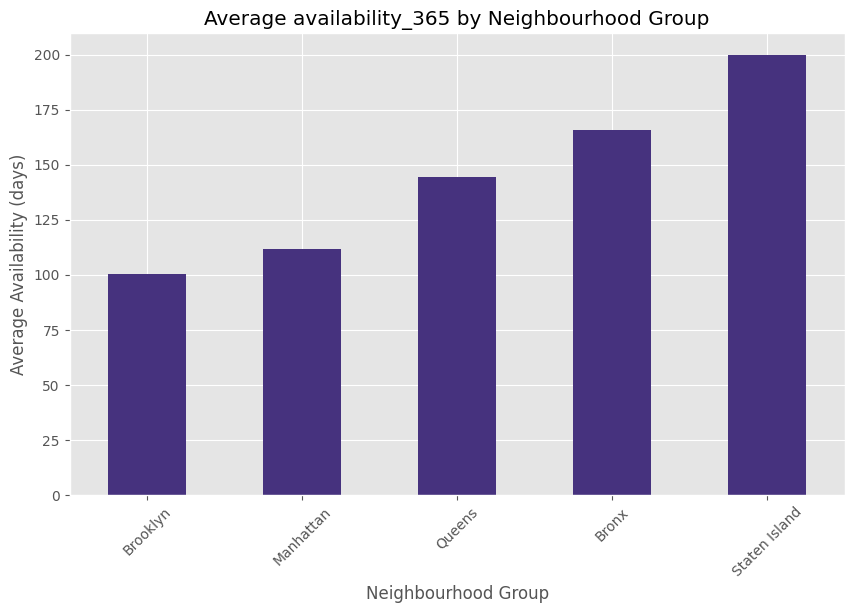

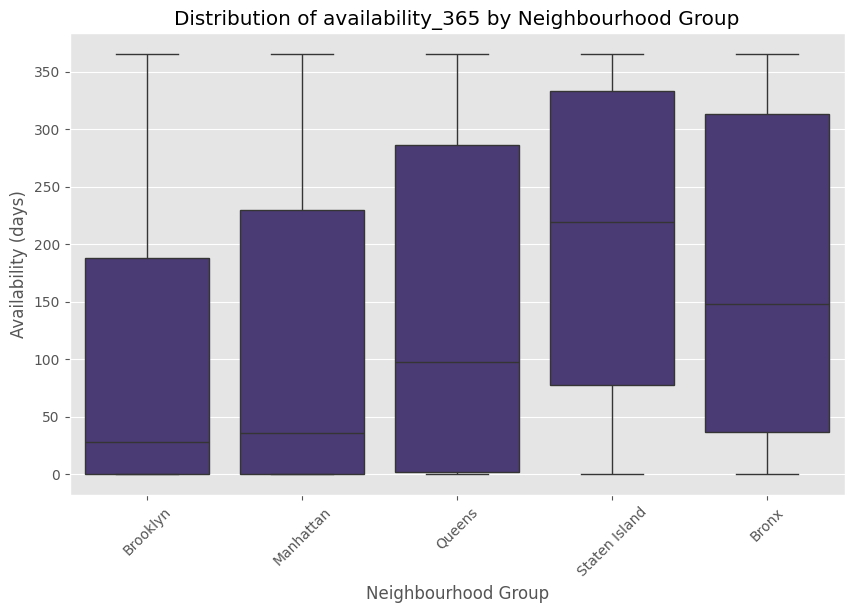


Top 10 Neighbourhoods with Lowest Average availability_365:
neighbourhood
Bay Terrace, Staten Island     0.000000
New Dorp                       0.000000
Woodrow                        0.000000
Downtown Brooklyn             39.481928
Morningside Heights           43.054913
Navy Yard                     48.928571
Rossville                     59.000000
Cobble Hill                   63.212121
Stuyvesant Town               65.108108
New Springville               65.250000
Name: availability_365, dtype: float64

Top 10 Neighbourhoods with Highest Average availability_365:
neighbourhood
Spuyten Duyvil    270.000000
West Brighton     274.722222
Randall Manor     275.210526
Edgemere          275.272727
Mill Basin        290.000000
Richmondtown      300.000000
Eastchester       333.461538
Willowbrook       351.000000
Co-op City        364.000000
Fort Wadsworth    365.000000
Name: availability_365, dtype: float64


In [12]:
print("\n--- Availability Analysis: Per neighbourhood_group and neighbourhood ---")

# Average availability per neighbourhood_group
avg_availability_group = df.groupby('neighbourhood_group')['availability_365'].mean().sort_values(ascending=True)
print("\nAverage availability_365 per neighbourhood_group (Sorted by least available):")
print(avg_availability_group)

plt.figure(figsize=(10, 6))
avg_availability_group.plot(kind='bar')
plt.title('Average availability_365 by Neighbourhood Group')
plt.ylabel('Average Availability (days)')
plt.xlabel('Neighbourhood Group')
plt.xticks(rotation=45)
plt.show()

# Box plot of availability_365 by neighbourhood_group
plt.figure(figsize=(10, 6))
sns.boxplot(x='neighbourhood_group', y='availability_365', data=df)
plt.title('Distribution of availability_365 by Neighbourhood Group')
plt.ylabel('Availability (days)')
plt.xlabel('Neighbourhood Group')
plt.xticks(rotation=45)
plt.show()

# Top 10 neighbourhoods with lowest average availability (potentially "busiest" by this metric)
avg_availability_neighbourhood = df.groupby('neighbourhood')['availability_365'].mean().sort_values(ascending=True)
print("\nTop 10 Neighbourhoods with Lowest Average availability_365:")
print(avg_availability_neighbourhood.head(10))

# Top 10 neighbourhoods with highest average availability
print("\nTop 10 Neighbourhoods with Highest Average availability_365:")
print(avg_availability_neighbourhood.tail(10))

2.4 Overall Distribution (number_of_reviews, reviews_per_month)


--- Review Metrics: Overall Distribution ---


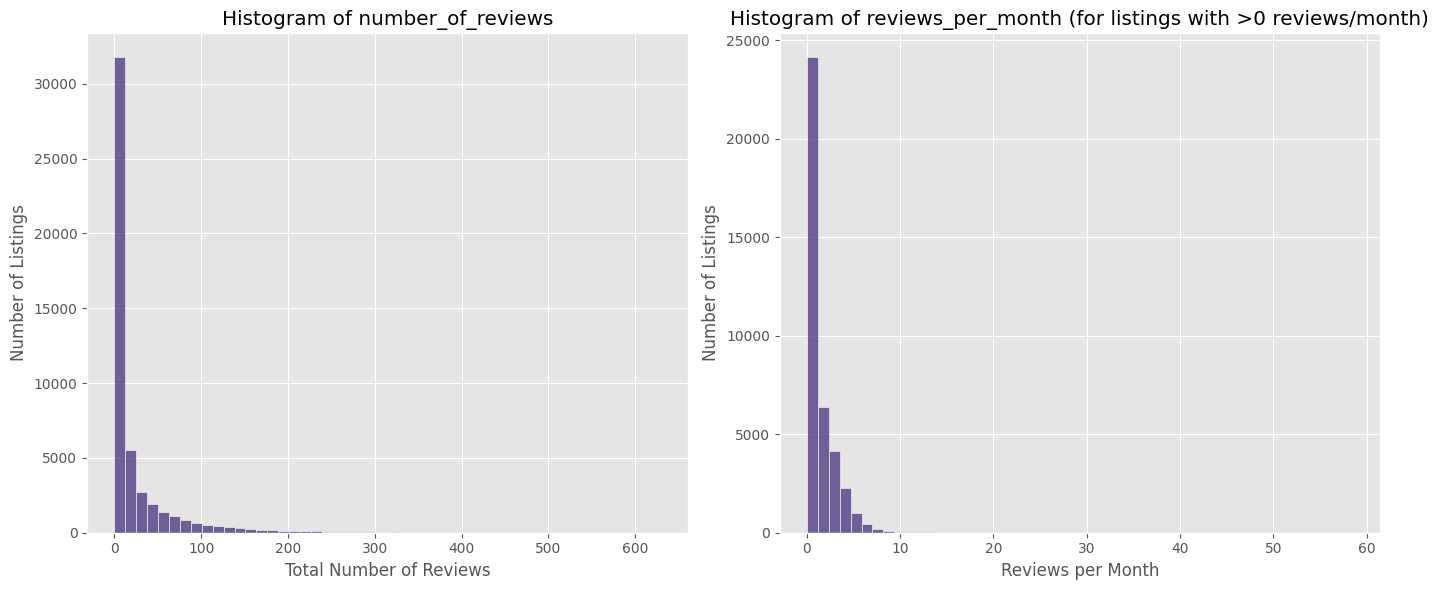


Description of number_of_reviews:
count    48895.000000
mean        23.274466
std         44.550582
min          0.000000
25%          1.000000
50%          5.000000
75%         24.000000
max        629.000000
Name: number_of_reviews, dtype: float64

Description of reviews_per_month (ensure NaNs were handled, e.g., filled with 0):
count    48895.000000
mean         1.090910
std          1.597283
min          0.000000
25%          0.040000
50%          0.370000
75%          1.580000
max         58.500000
Name: reviews_per_month, dtype: float64


In [13]:
print("\n--- Review Metrics: Overall Distribution ---")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['number_of_reviews'], bins=50, kde=False)
plt.title('Histogram of number_of_reviews')
plt.xlabel('Total Number of Reviews')
plt.ylabel('Number of Listings')
# May need to set xlim due to skewness for better visualization
# plt.xlim(0, df['number_of_reviews'].quantile(0.95)) # Example: view up to 95th percentile

plt.subplot(1, 2, 2)
sns.histplot(df[df['reviews_per_month'] > 0]['reviews_per_month'], bins=50, kde=False) # Exclude 0 for a better view of active listings
plt.title('Histogram of reviews_per_month (for listings with >0 reviews/month)')
plt.xlabel('Reviews per Month')
plt.ylabel('Number of Listings')
# May need to set xlim due to skewness
# plt.xlim(0, df['reviews_per_month'].quantile(0.95)) # Example

plt.tight_layout()
plt.show()

print("\nDescription of number_of_reviews:")
print(df['number_of_reviews'].describe())
print("\nDescription of reviews_per_month (ensure NaNs were handled, e.g., filled with 0):")
print(df['reviews_per_month'].describe())

2.5 Review Metrics - Per neighbourhood_group and neighbourhood


--- Review Metrics: Per neighbourhood_group and neighbourhood ---

Average reviews_per_month per neighbourhood_group (Sorted by most active):
neighbourhood_group
Staten Island    1.576381
Queens           1.567076
Bronx            1.475655
Brooklyn         1.049790
Manhattan        0.976782
Name: reviews_per_month, dtype: float64


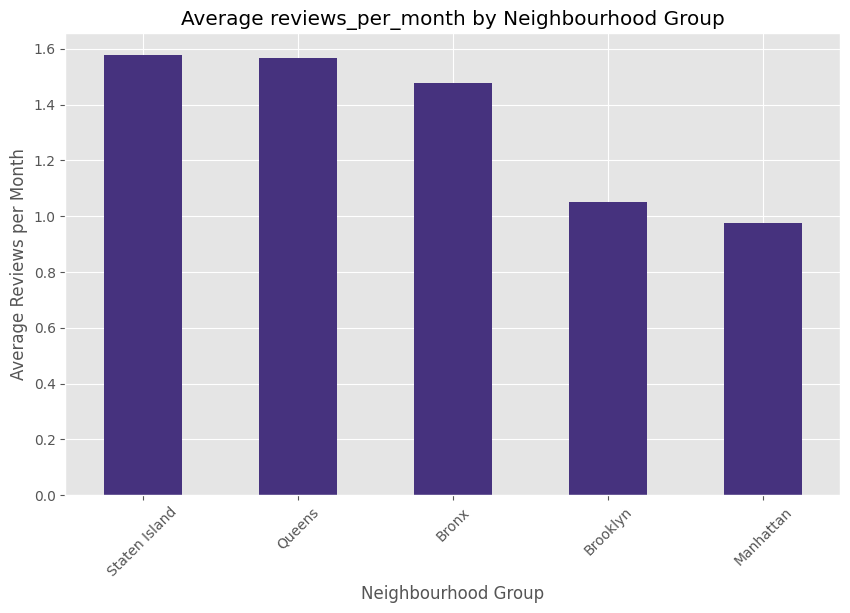

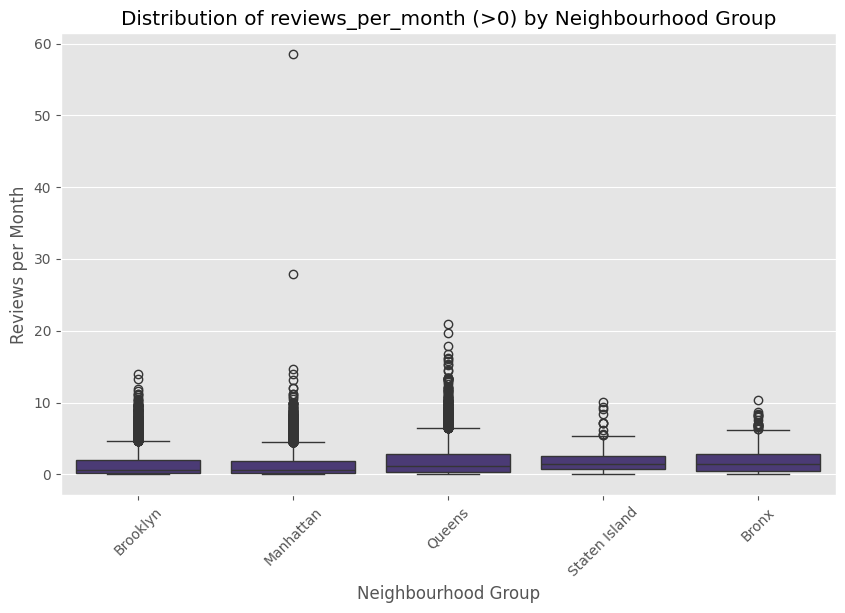


Top 10 Neighbourhoods with Highest Average reviews_per_month:
neighbourhood
East Elmhurst          4.458000
Silver Lake            4.340000
Springfield Gardens    4.193176
Rosebank               3.812857
Huguenot               3.760000
Schuylerville          3.157692
South Ozone Park       3.019750
Jamaica Hills          2.901250
Queens Village         2.684000
Fresh Meadows          2.646875
Name: reviews_per_month, dtype: float64


In [14]:
print("\n--- Review Metrics: Per neighbourhood_group and neighbourhood ---")

# Average reviews_per_month per neighbourhood_group
# Ensure reviews_per_month does not have NaNs before this step (e.g., filled with 0)
avg_reviews_group = df.groupby('neighbourhood_group')['reviews_per_month'].mean().sort_values(ascending=False)
print("\nAverage reviews_per_month per neighbourhood_group (Sorted by most active):")
print(avg_reviews_group)

plt.figure(figsize=(10, 6))
avg_reviews_group.plot(kind='bar')
plt.title('Average reviews_per_month by Neighbourhood Group')
plt.ylabel('Average Reviews per Month')
plt.xlabel('Neighbourhood Group')
plt.xticks(rotation=45)
plt.show()

# Box plot of reviews_per_month by neighbourhood_group (for listings with reviews_per_month > 0)
plt.figure(figsize=(10, 6))
sns.boxplot(x='neighbourhood_group', y='reviews_per_month', data=df[df['reviews_per_month'] > 0])
plt.title('Distribution of reviews_per_month (>0) by Neighbourhood Group')
plt.ylabel('Reviews per Month')
plt.xlabel('Neighbourhood Group')
plt.xticks(rotation=45)
# Consider using plt.ylim to zoom in if outliers are too extreme
# plt.ylim(0, df[df['reviews_per_month'] > 0]['reviews_per_month'].quantile(0.95))
plt.show()

# Top 10 neighbourhoods with highest average reviews_per_month (potentially "busiest" by this metric)
avg_reviews_neighbourhood = df.groupby('neighbourhood')['reviews_per_month'].mean().sort_values(ascending=False)
print("\nTop 10 Neighbourhoods with Highest Average reviews_per_month:")
print(avg_reviews_neighbourhood.head(10))

2.6 Listing Density Analysis


--- Listing Density Analysis ---

Listing Density (Count) per neighbourhood_group:
neighbourhood_group
Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: id, dtype: int64


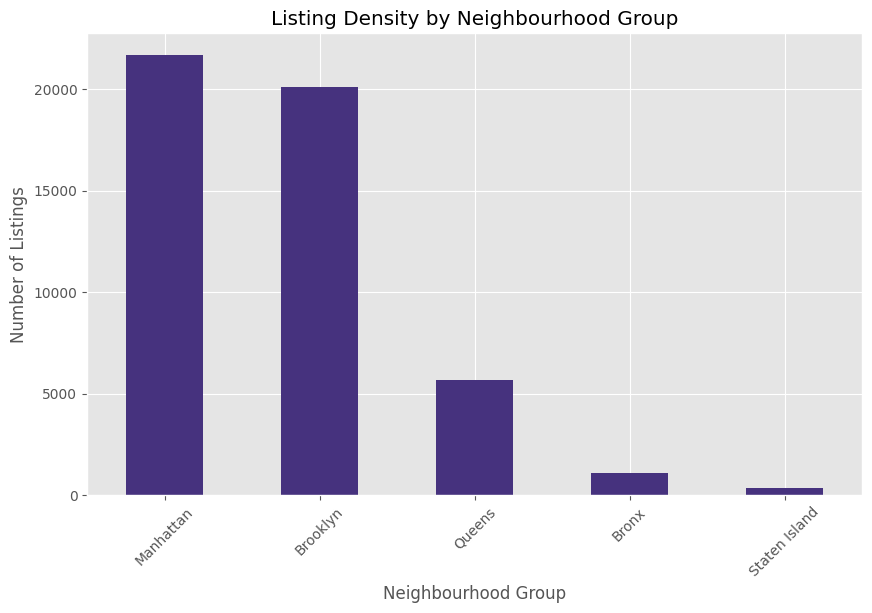


Top 10 Neighbourhoods with Highest Listing Density:
neighbourhood
Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
Hell's Kitchen        1958
East Village          1853
Upper East Side       1798
Crown Heights         1564
Midtown               1545
Name: id, dtype: int64


In [15]:
print("\n--- Listing Density Analysis ---")

# Listing density per neighbourhood_group
density_group = df.groupby('neighbourhood_group')['id'].count().sort_values(ascending=False)
print("\nListing Density (Count) per neighbourhood_group:")
print(density_group)

plt.figure(figsize=(10, 6))
density_group.plot(kind='bar')
plt.title('Listing Density by Neighbourhood Group')
plt.ylabel('Number of Listings')
plt.xlabel('Neighbourhood Group')
plt.xticks(rotation=45)
plt.show()

# Top 10 neighbourhoods with highest listing density
density_neighbourhood = df.groupby('neighbourhood')['id'].count().sort_values(ascending=False)
print("\nTop 10 Neighbourhoods with Highest Listing Density:")
print(density_neighbourhood.head(10))

2.7 Correlations for Busyness (at Neighbourhood Level)


--- Correlations for Busyness (at Neighbourhood Level) ---

Neighbourhood Level Stats (first 5 rows):
   neighbourhood  avg_availability_365  avg_reviews_per_month  listing_density
0       Allerton            163.666667               1.615714               42
1  Arden Heights             94.250000               1.040000                4
2       Arrochar            255.809524               1.060952               21
3        Arverne            188.428571               1.515455               77
4        Astoria            109.191111               1.001411              900

Correlation matrix for potential busyness indicators:
                          inverse_avg_availability  avg_reviews_per_month  \
inverse_avg_availability                  1.000000              -0.190497   
avg_reviews_per_month                    -0.190497               1.000000   
listing_density                          -0.048217              -0.136348   

                          listing_density  
inverse_avg_ava

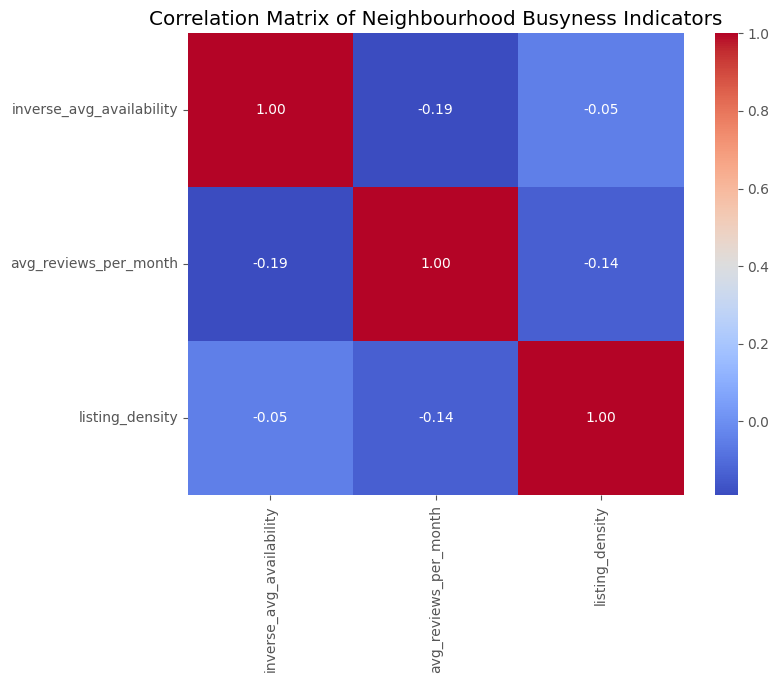


Interpretation of Correlation Matrix:
- Positive values close to 1 indicate strong positive correlation.
- Negative values close to -1 indicate strong negative correlation.
- Values close to 0 indicate weak or no linear correlation.
This helps understand if these metrics move together and could form parts of a composite 'busyness' score.


In [16]:
print("\n--- Correlations for Busyness (at Neighbourhood Level) ---")

# 1. Create a neighbourhood-level DataFrame
neighbourhood_stats = df.groupby('neighbourhood').agg(
    avg_availability_365=('availability_365', 'mean'),
    avg_reviews_per_month=('reviews_per_month', 'mean'), # Assumes reviews_per_month NaNs handled
    listing_density=('id', 'count')
).reset_index()

print("\nNeighbourhood Level Stats (first 5 rows):")
print(neighbourhood_stats.head())

# 2. Calculate the correlation matrix
# For busyness, we expect:
# - avg_availability_365 to be negatively correlated with busyness (lower availability = busier)
# - avg_reviews_per_month to be positively correlated with busyness
# - listing_density to be positively correlated with busyness
# So, let's make 'inverse_avg_availability' for easier interpretation in correlation
neighbourhood_stats['inverse_avg_availability'] = 1 / (neighbourhood_stats['avg_availability_365'] + 0.001) # Add small constant to avoid division by zero

busyness_features_corr = neighbourhood_stats[['inverse_avg_availability', 'avg_reviews_per_month', 'listing_density']].corr()

print("\nCorrelation matrix for potential busyness indicators:")
print(busyness_features_corr)

# 3. Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(busyness_features_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Neighbourhood Busyness Indicators')
plt.show()

print("\nInterpretation of Correlation Matrix:")
print("- Positive values close to 1 indicate strong positive correlation.")
print("- Negative values close to -1 indicate strong negative correlation.")
print("- Values close to 0 indicate weak or no linear correlation.")
print("This helps understand if these metrics move together and could form parts of a composite 'busyness' score.")

Summary of Step 2 - 

Availability (availability_365): A significant portion of listings (over 35%) have zero availability, and half have 45 days or less. Brooklyn and Manhattan show the lowest average availability at the borough level, while specific neighborhoods across different boroughs show extreme highs and lows.

Review Activity (number_of_reviews, reviews_per_month): Most listings have few total reviews and low monthly review rates, indicating skewed distributions where a minority of listings are highly active. Surprisingly, outer boroughs (Staten Island, Queens, Bronx) showed higher average reviews per month per listing than the denser Manhattan and Brooklyn. Specific neighborhoods, often in these outer boroughs, had listings with very high average review velocity.

Listing Density: Manhattan and Brooklyn neighborhoods overwhelmingly have the highest concentration of listings.
Correlations: The neighborhood-level aggregated metrics for busyness (based on inverse availability, average reviews per month, and listing density) showed weak, and sometimes counterintuitive (negative), linear correlations. This suggests these three aspects of "busyness" don't necessarily increase or decrease together.

3. Defining "Similarity" of Listings and Neighborhoods

3.1 Price Analysis

3.1.1 Overall Price Distribution & Outlier Check 

--- Overall Price Distribution ---
Descriptive statistics for 'price':
count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64


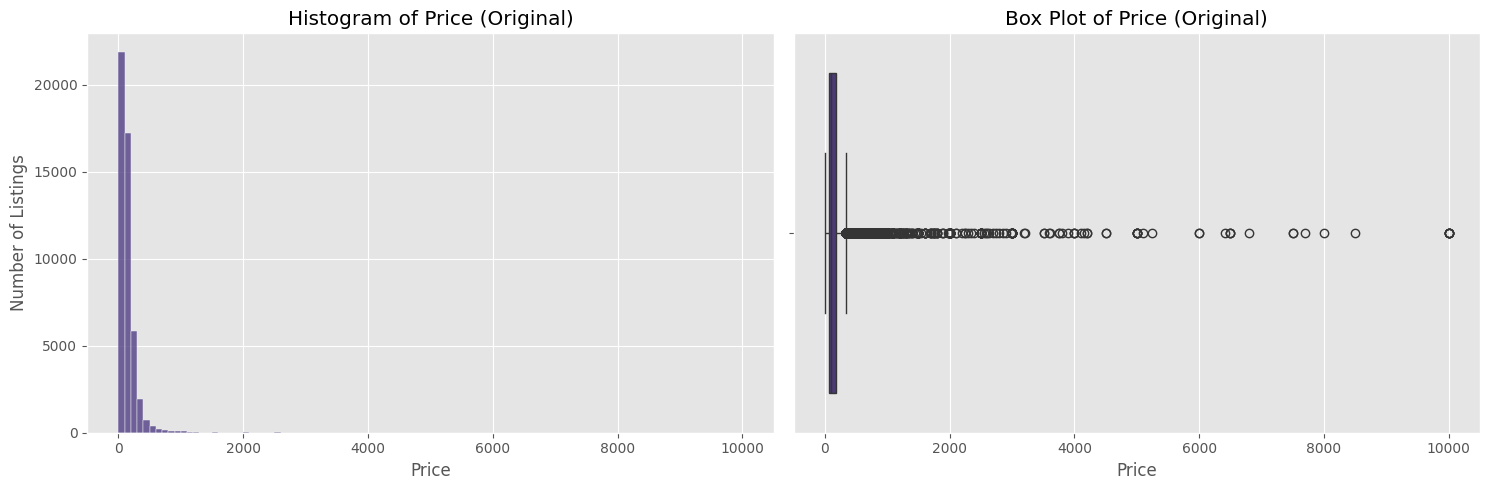


Observations from original price distribution:
- The 'describe()' output and plots likely show significant right-skewness due to outliers (very expensive listings).
- The max price might be very far from the mean and median.
- This skewness can make it hard to visualize the distribution for the majority of listings.
Consider a log transformation for better visualization of the bulk of data and for some modeling techniques.


In [17]:
print("--- Overall Price Distribution ---")
print("Descriptive statistics for 'price':")
print(df['price'].describe())

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['price'], bins=100, kde=False)
plt.title('Histogram of Price (Original)')
plt.xlabel('Price')
plt.ylabel('Number of Listings')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['price'])
plt.title('Box Plot of Price (Original)')
plt.xlabel('Price')

plt.tight_layout()
plt.show()


3.1.1 (b) Same as above but with log transformations for visualizations


--- Price Distribution (Log Transformed for Visualization) ---


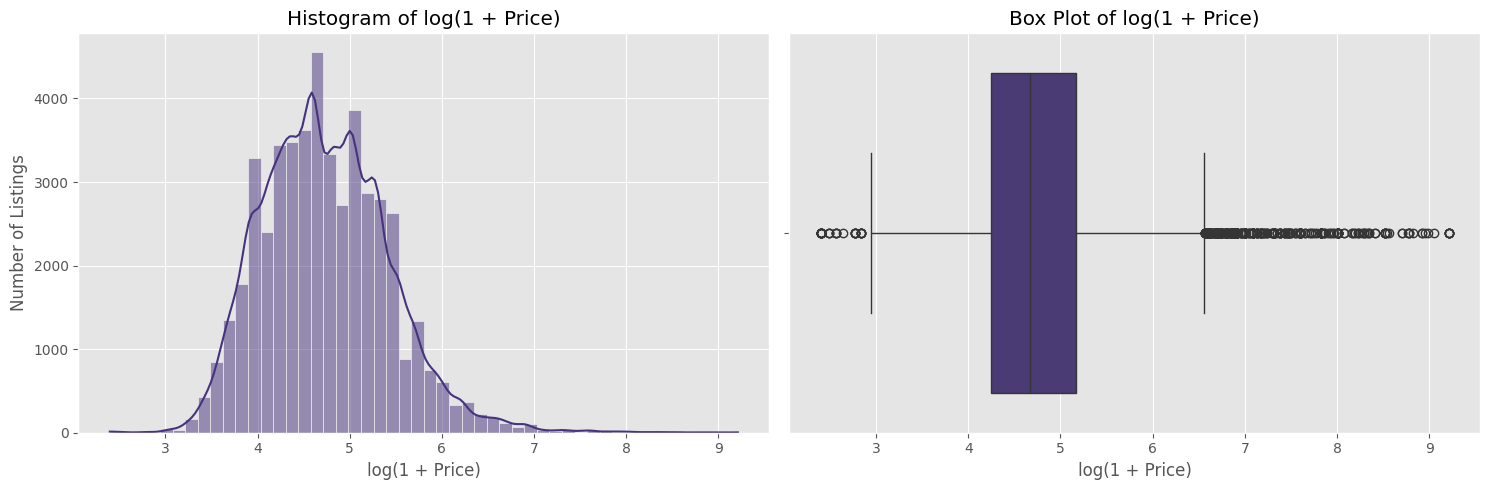

In [18]:
print("\n--- Price Distribution (Log Transformed for Visualization) ---")
df_log_price = df[df['price'] > 0]['price']
log_price = np.log1p(df_log_price)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(log_price, bins=50, kde=True)
plt.title('Histogram of log(1 + Price)')
plt.xlabel('log(1 + Price)')
plt.ylabel('Number of Listings')

plt.subplot(1, 2, 2)
sns.boxplot(x=log_price)
plt.title('Box Plot of log(1 + Price)')
plt.xlabel('log(1 + Price)')

plt.tight_layout()
plt.show()

3.1.2 Price Distribution per room_type


--- Price Distribution per room_type ---


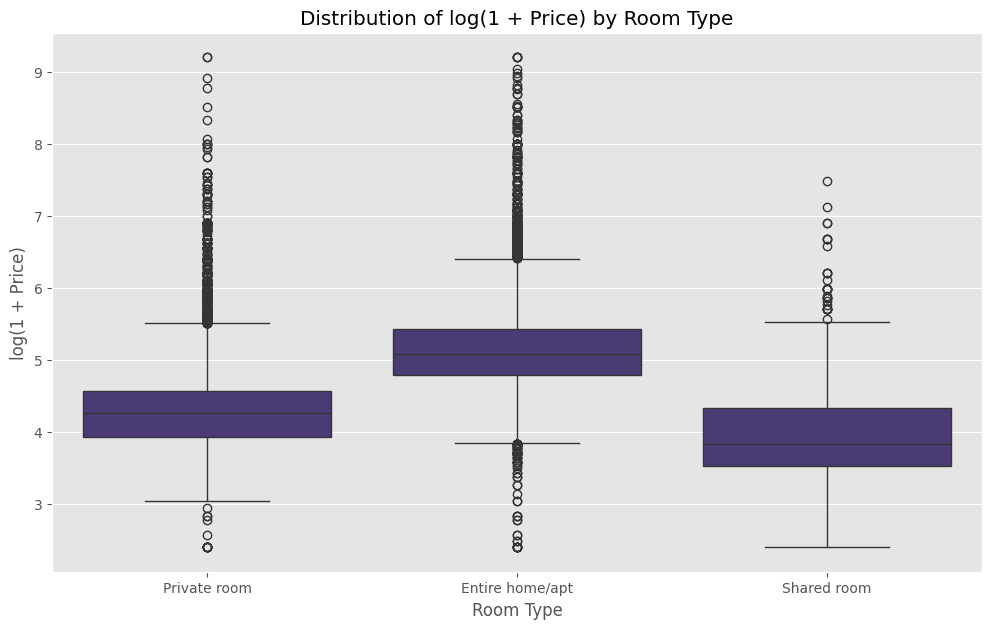

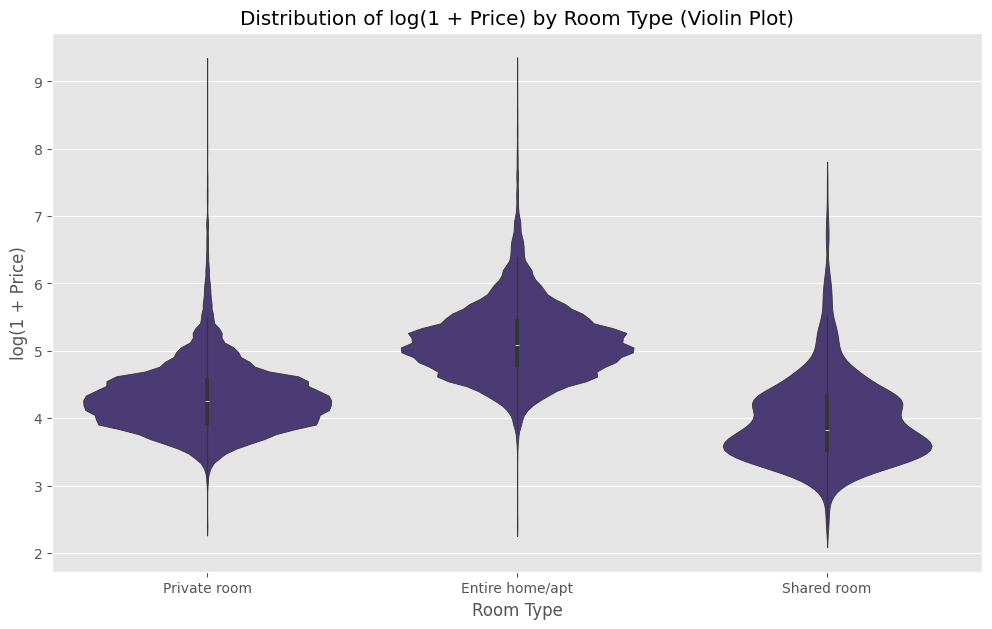


Average and Median price per room_type:
                       mean  median  count
room_type                                 
Entire home/apt  211.794246   160.0  25409
Private room      89.780973    70.0  22326
Shared room       70.127586    45.0   1160


In [19]:
print("\n--- Price Distribution per room_type ---")

price_to_plot = np.log1p(df[df['price'] > 0]['price']) 
y_label_plot = 'log(1 + Price)' # Or 'Price'

plt.figure(figsize=(12, 7))
sns.boxplot(x='room_type', y=price_to_plot, data=df[df['price'] > 0]) # Ensure data matches price_to_plot
plt.title(f'Distribution of {y_label_plot} by Room Type')
plt.xlabel('Room Type')
plt.ylabel(y_label_plot)
plt.show()

plt.figure(figsize=(12, 7))
sns.violinplot(x='room_type', y=price_to_plot, data=df[df['price'] > 0])
plt.title(f'Distribution of {y_label_plot} by Room Type (Violin Plot)')
plt.xlabel('Room Type')
plt.ylabel(y_label_plot)
plt.show()

print("\nAverage and Median price per room_type:")
print(df.groupby('room_type')['price'].agg(['mean', 'median', 'count']).sort_values(by='median', ascending=False))

3.1.3 Price Distribution per neighbourhood_group


--- Price Distribution per neighbourhood_group ---


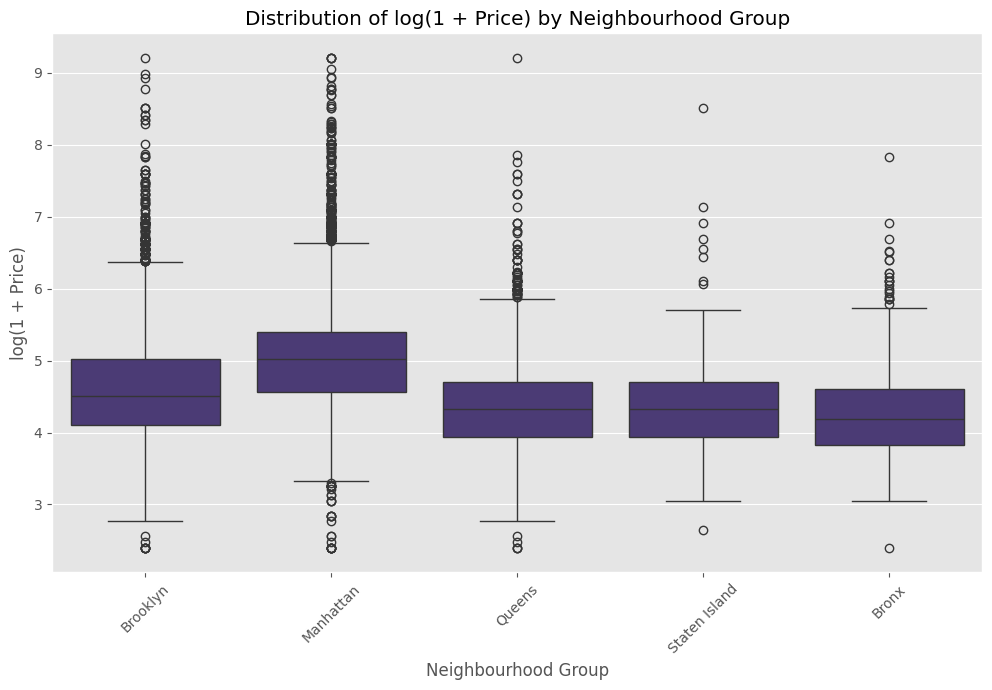


Average and Median price per neighbourhood_group:
                           mean  median  count
neighbourhood_group                           
Manhattan            196.875814   150.0  21661
Brooklyn             124.383207    90.0  20104
Queens                99.517649    75.0   5666
Staten Island        114.812332    75.0    373
Bronx                 87.496792    65.0   1091


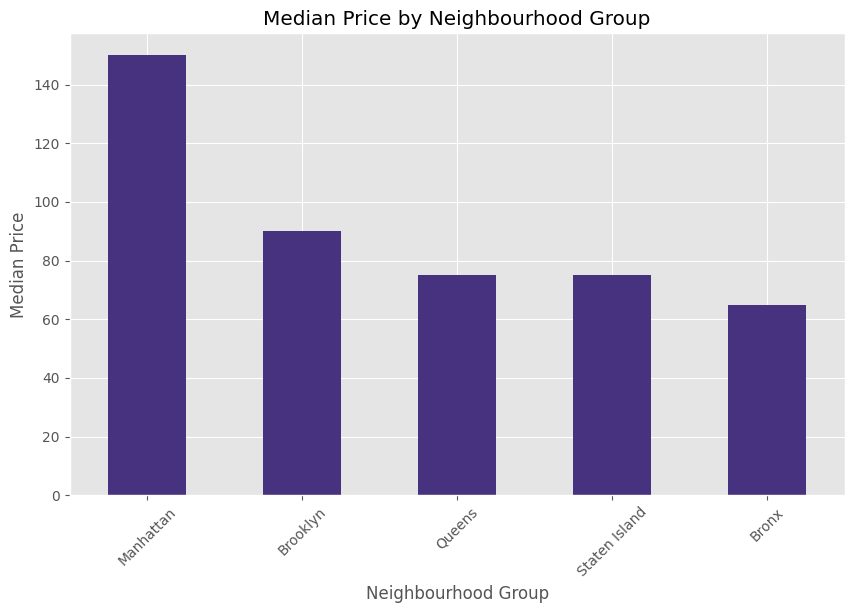

In [20]:
print("\n--- Price Distribution per neighbourhood_group ---")

plt.figure(figsize=(12, 7))
sns.boxplot(x='neighbourhood_group', y=price_to_plot, data=df[df['price'] > 0])
plt.title(f'Distribution of {y_label_plot} by Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel(y_label_plot)
plt.xticks(rotation=45)
plt.show()

print("\nAverage and Median price per neighbourhood_group:")
avg_price_borough = df.groupby('neighbourhood_group')['price'].agg(['mean', 'median', 'count']).sort_values(by='median', ascending=False)
print(avg_price_borough)

plt.figure(figsize=(10, 6))
avg_price_borough['median'].plot(kind='bar')
plt.title('Median Price by Neighbourhood Group')
plt.ylabel('Median Price')
plt.xlabel('Neighbourhood Group')
plt.xticks(rotation=45)
plt.show()

3.1.4 Price Distribution per neighbourhood (Focused Analysis)


--- Price Distribution per neighbourhood (Example: Top 10 most common) ---
Analyzing price for Top 10 most common neighbourhoods: ['Williamsburg', 'Bedford-Stuyvesant', 'Harlem', 'Bushwick', 'Upper West Side', "Hell's Kitchen", 'East Village', 'Upper East Side', 'Crown Heights', 'Midtown']


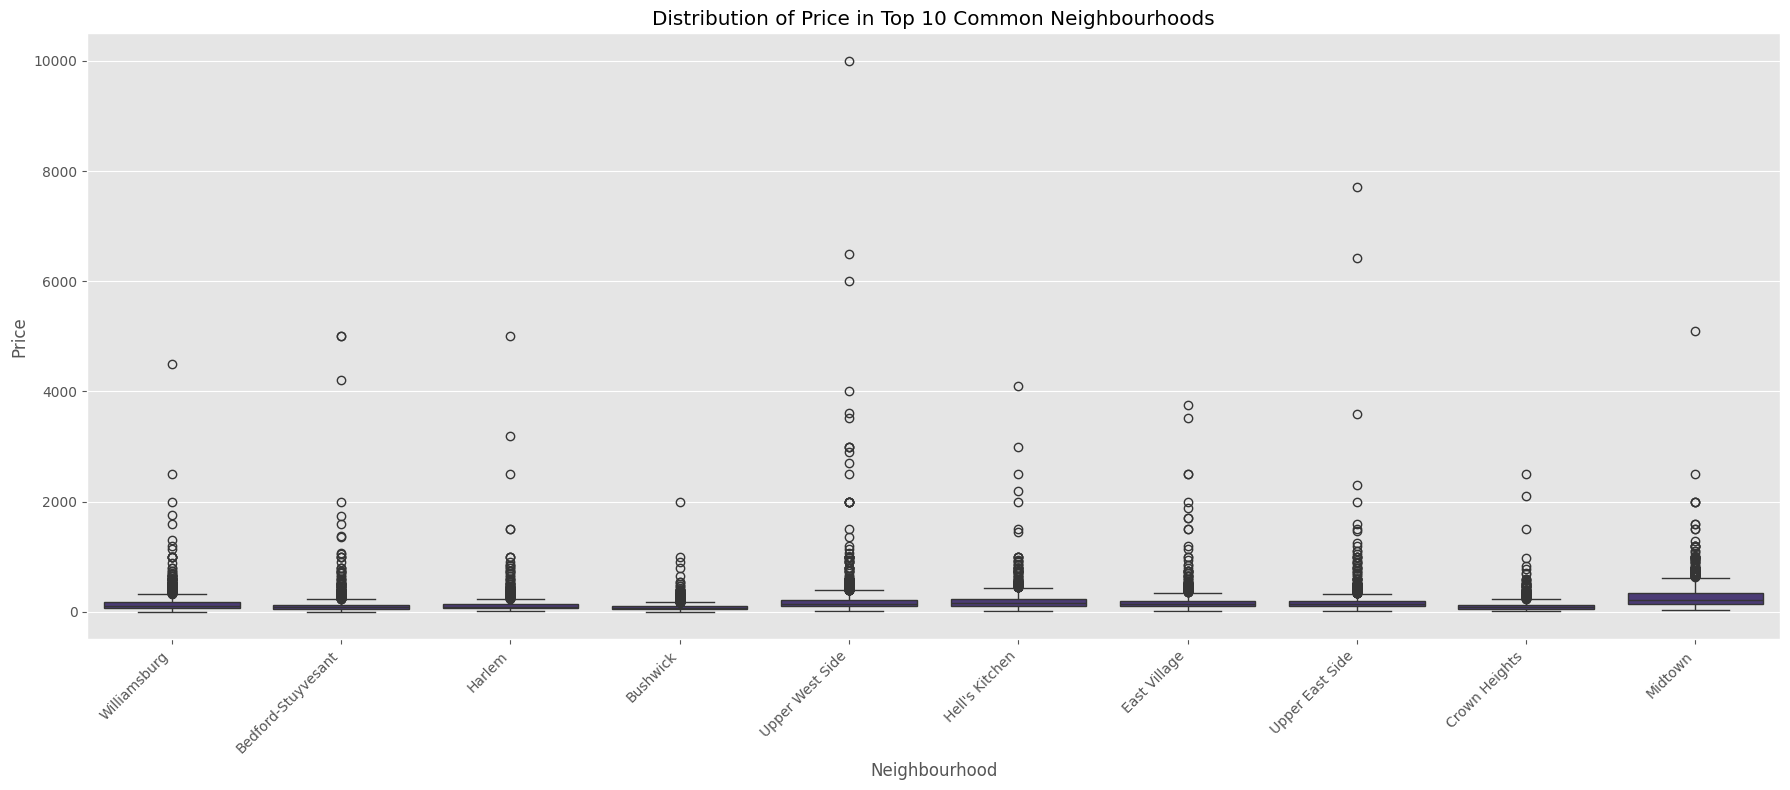


Average and Median price for Top 10 most common neighbourhoods:
                          mean  median  count
neighbourhood                                
Williamsburg        143.802806   105.0   3920
Bedford-Stuyvesant  107.678244    80.0   3714
Harlem              118.974041    89.0   2658
Bushwick             84.800406    65.0   2465
Upper West Side     210.918316   150.0   1971
Hell's Kitchen      204.794178   168.0   1958
East Village        186.083108   150.0   1853
Upper East Side     188.948276   149.0   1798
Crown Heights       112.480179    85.0   1564
Midtown             282.719094   210.0   1545


In [21]:
print("\n--- Price Distribution per neighbourhood (Example: Top 10 most common) ---")

# Find the top 10 most common neighborhoods
top_10_neighbourhoods = df['neighbourhood'].value_counts().nlargest(10).index
print(f"Analyzing price for Top 10 most common neighbourhoods: {list(top_10_neighbourhoods)}")

# Filter the DataFrame for these top 10 neighborhoods
df_top_neighbourhoods = df[df['neighbourhood'].isin(top_10_neighbourhoods)]

# Using log_price for visualization
price_to_plot_neigh = np.log1p(df_top_neighbourhoods[df_top_neighbourhoods['price'] > 0]['price'])
y_label_plot_neigh = 'log(1 + Price)'


plt.figure(figsize=(18, 8))
sns.boxplot(x='neighbourhood', y='price', data=df_top_neighbourhoods, order=top_10_neighbourhoods)
plt.title(f'Distribution of Price in Top 10 Common Neighbourhoods')
plt.xlabel('Neighbourhood')
plt.ylabel('Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nAverage and Median price for Top 10 most common neighbourhoods:")
avg_price_top_neigh = df_top_neighbourhoods.groupby('neighbourhood')['price'].agg(['mean', 'median', 'count']).reindex(top_10_neighbourhoods) # Keep original order
print(avg_price_top_neigh)

3.2 Room Type Analysis

3.2.1 Overall room_type Distribution

--- Overall Room Type Distribution ---
Frequency of each room_type:
room_type
Entire home/apt    25409
Private room       22326
Shared room         1160
Name: count, dtype: int64

Proportion of each room_type (%):
room_type
Entire home/apt    51.966459
Private room       45.661111
Shared room         2.372431
Name: proportion, dtype: float64


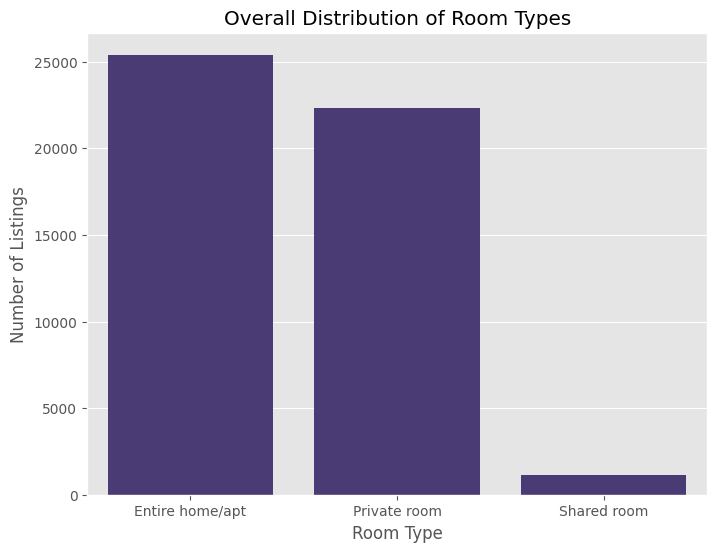

In [22]:
print("--- Overall Room Type Distribution ---")

# Frequency counts
room_type_counts = df['room_type'].value_counts()
print("Frequency of each room_type:")
print(room_type_counts)

# Proportions
room_type_proportions = df['room_type'].value_counts(normalize=True) * 100
print("\nProportion of each room_type (%):")
print(room_type_proportions)

# Visualization
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='room_type', order=room_type_counts.index) # Order by frequency
plt.title('Overall Distribution of Room Types')
plt.xlabel('Room Type')
plt.ylabel('Number of Listings')
plt.show()

3.2.2 room_type Distribution per neighbourhood_group


--- Room Type Distribution per Neighbourhood Group ---
Counts of room_type within each neighbourhood_group:
room_type            Entire home/apt  Private room  Shared room
neighbourhood_group                                            
Bronx                            379           652           60
Brooklyn                        9559         10132          413
Manhattan                      13199          7982          480
Queens                          2096          3372          198
Staten Island                    176           188            9

Proportions (%) of room_type within each neighbourhood_group:
room_type            Entire home/apt  Private room  Shared room
neighbourhood_group                                            
Bronx                      34.738772     59.761687     5.499542
Brooklyn                   47.547752     50.397931     2.054318
Manhattan                  60.934398     36.849638     2.215964
Queens                     36.992587     59.512884     3.494

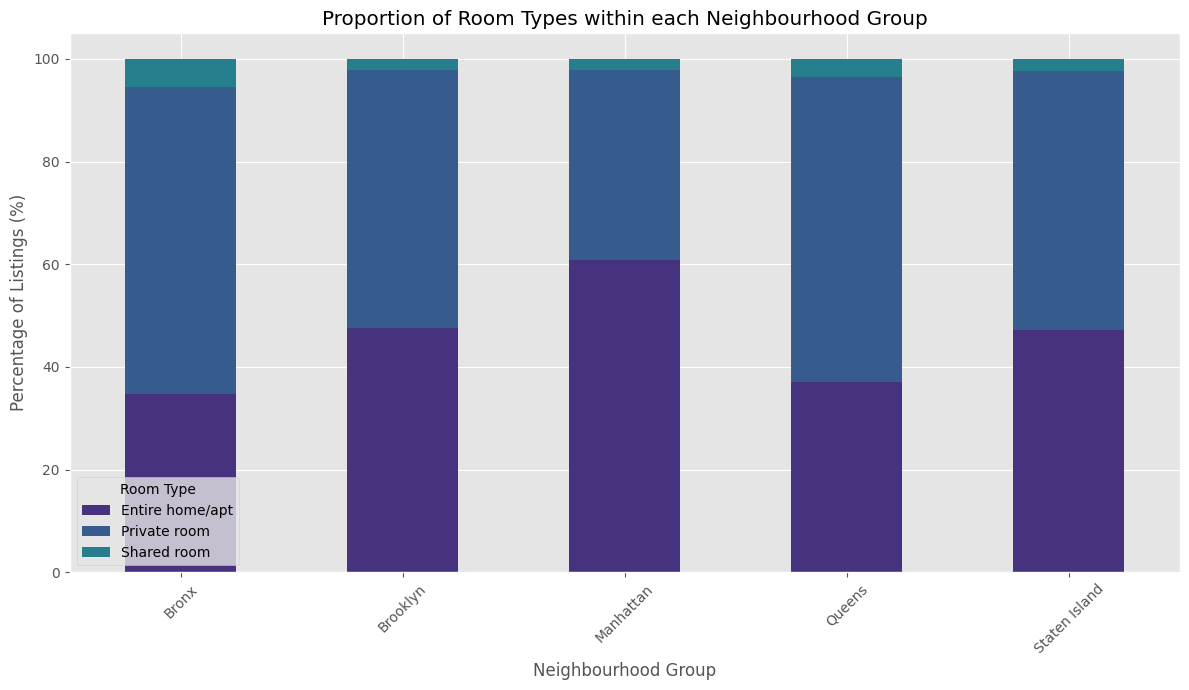

<Figure size 1200x700 with 0 Axes>

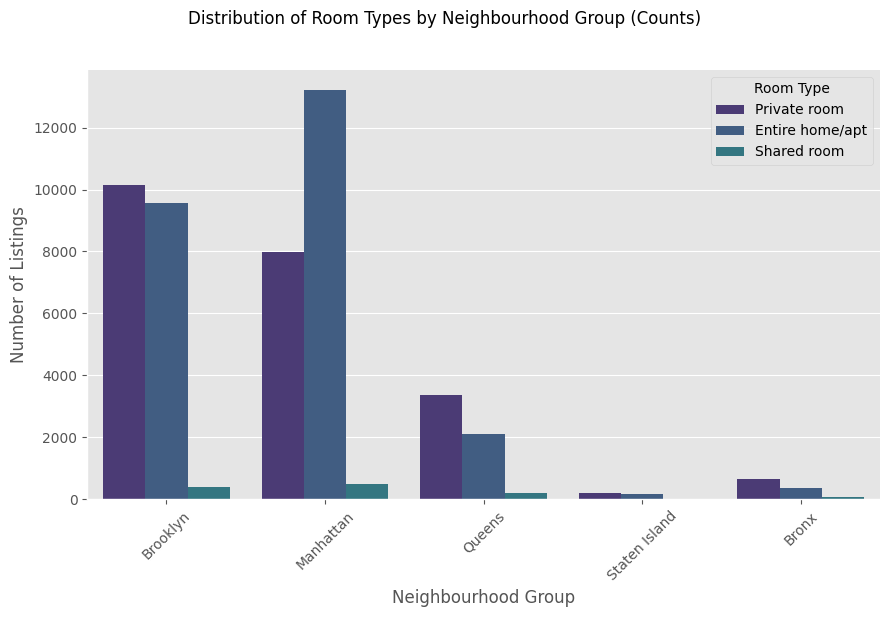

In [23]:
print("\n--- Room Type Distribution per Neighbourhood Group ---")

# Grouped counts
group_room_counts = df.groupby('neighbourhood_group')['room_type'].value_counts(normalize=False).unstack(fill_value=0)
print("Counts of room_type within each neighbourhood_group:")
print(group_room_counts)

# Proportions for stacked bar chart
group_room_proportions = df.groupby('neighbourhood_group')['room_type'].value_counts(normalize=True).mul(100).unstack(fill_value=0)
print("\nProportions (%) of room_type within each neighbourhood_group:")
print(group_room_proportions)

# Visualization - Stacked Bar Chart for Proportions
group_room_proportions.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Proportion of Room Types within each Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Percentage of Listings (%)')
plt.xticks(rotation=45)
plt.legend(title='Room Type')
plt.tight_layout()
plt.show()

# Alternative Visualization - Grouped Bar Chart for Counts (using catplot)
plt.figure(figsize=(12, 7)) # May need to adjust figure size if using catplot separately
g = sns.catplot(data=df, x='neighbourhood_group', hue='room_type', kind='count', height=6, aspect=1.5, legend_out=False)
g.set_axis_labels("Neighbourhood Group", "Number of Listings")
g.fig.suptitle('Distribution of Room Types by Neighbourhood Group (Counts)', y=1.02) # Adjust title position
plt.xticks(rotation=45)
plt.legend(title='Room Type')
plt.tight_layout() # Apply to the figure of the catplot
plt.show()

3.2.2 (b) room_type Distribution per neighbourhood (Focused)


--- Room Type Distribution per Neighbourhood (Example: Top 5 Most Common) ---
Analyzing room type distribution for Top 5 most common neighbourhoods: ['Williamsburg', 'Bedford-Stuyvesant', 'Harlem', 'Bushwick', 'Upper West Side']

Proportions (%) of room_type within selected top neighbourhoods:
room_type           Entire home/apt  Private room  Shared room
neighbourhood                                                 
Williamsburg              48.239796     50.943878     0.816327
Bedford-Stuyvesant        42.837911     54.873452     2.288638
Harlem                    38.976674     59.179834     1.843491
Bushwick                  27.505071     69.736308     2.758621
Upper West Side           63.723998     34.246575     2.029427


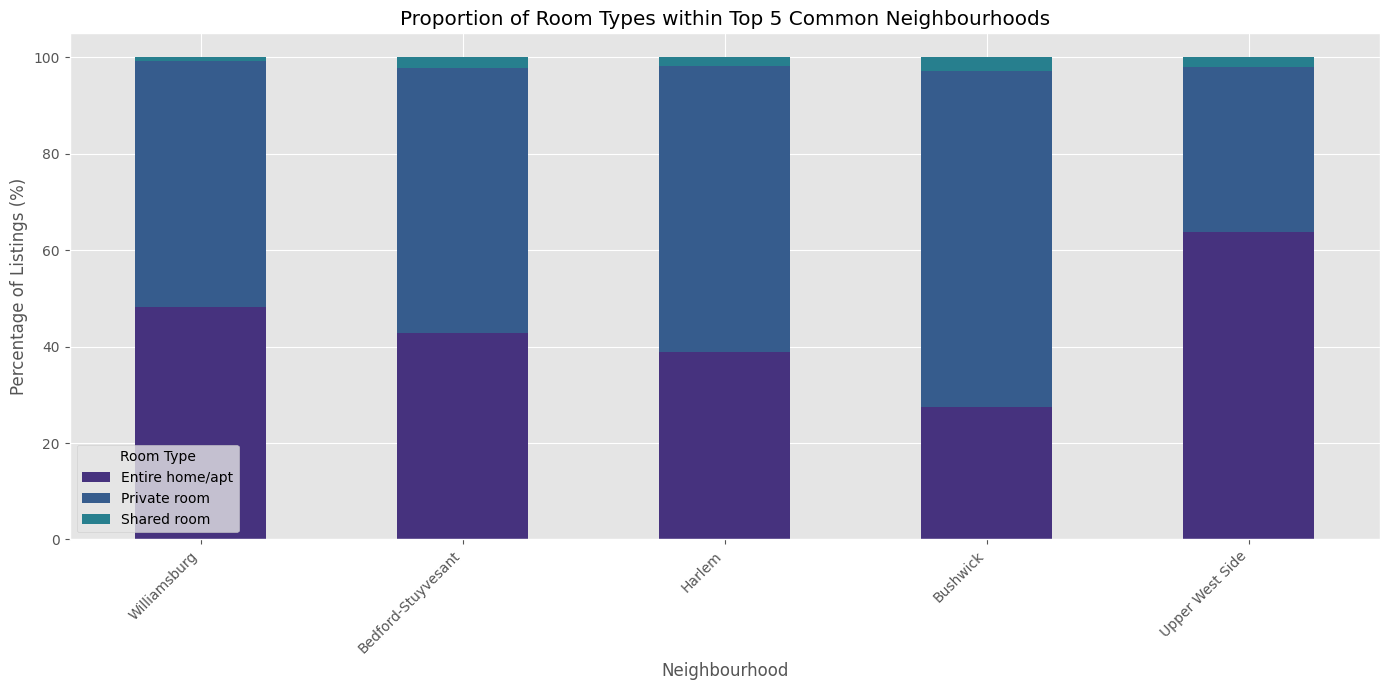

In [24]:
print("\n--- Room Type Distribution per Neighbourhood (Example: Top 5 Most Common) ---")

# Find the top 5 most common neighborhoods
top_5_neighbourhoods = df['neighbourhood'].value_counts().nlargest(5).index
print(f"Analyzing room type distribution for Top 5 most common neighbourhoods: {list(top_5_neighbourhoods)}")

# Filter the DataFrame for these top 5 neighborhoods
df_top_neighbourhoods = df[df['neighbourhood'].isin(top_5_neighbourhoods)]

# Proportions for stacked bar chart for these specific neighborhoods
top_hoods_room_proportions = df_top_neighbourhoods.groupby('neighbourhood')['room_type'].value_counts(normalize=True).mul(100).unstack(fill_value=0)
print("\nProportions (%) of room_type within selected top neighbourhoods:")
print(top_hoods_room_proportions.reindex(top_5_neighbourhoods)) # Keep original order

# Visualization - Stacked Bar Chart for Proportions
if not top_hoods_room_proportions.empty:
    top_hoods_room_proportions.reindex(top_5_neighbourhoods).plot(kind='bar', stacked=True, figsize=(14, 7))
    plt.title('Proportion of Room Types within Top 5 Common Neighbourhoods')
    plt.xlabel('Neighbourhood')
    plt.ylabel('Percentage of Listings (%)')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Room Type')
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot for top neighbourhoods.")